# ASR decoder 

Example how to build an ASR decoder. We consider a decoder with the following lexicon:

|  Word | Pronunciation | 
|:-----:|:--------------|
| zero  | z e r o       |
| one   | o n e         |            
| two   | t w o         |
| three | t h r e e     |
| three | s r e e       |
| four  | f o u r       |
| five  | f i v e       |
| six   | s i x         |
| seven | s e v e n     |
| eight | e i g h t     |
| nine  | n i n e       |
 
Note that, for simplicity, we use the letters as phones. Also, every word has a single pronunciation except "three" which can be pronunced "three" and "sree".  

In [59]:
using Pkg
Pkg.activate("../")

using Revise
using MarkovModels

 Activating environment at `~/GithubRepositories/MarkovModels/Project.toml`


## HMMs

We build an HMM each phone (in this case letters). Each phone is modeled by a 3-state left-to-right HMM.

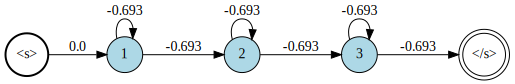

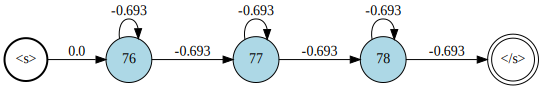

In [60]:
function makehmm(pdfidxs)
    fsm = FSM{Float64}()
    
    prevstate = initstate(fsm)
    for pdfidx in pdfidxs
        state = addstate!(fsm, pdfindex = pdfidx)
        link!(state, state)
        link!(prevstate, state)
        prevstate = state
    end
    link!(prevstate, finalstate(fsm))
    
    fsm |> weightnormalize
end

hmms = Dict()
countpdfs = 0
for (i, l) in enumerate('a':'z')
    startidx = 3 * (i -1) + 1
    countpdfs += 3
    hmms["$l"] = makehmm([startidx, startidx + 1, startidx + 2])
end

phones = collect('a':'z')

display(hmms["a"])
display(hmms["z"])

## Lexicon

Now we build the FSM lexicon

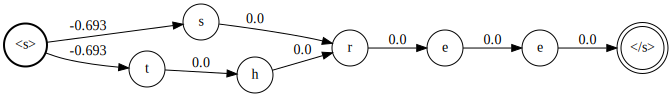

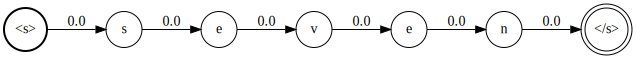

In [61]:
raw_lexicon = Dict(
    "zero"  => [("z", "e", "r", "o")],
    "one"   => [("o", "n", "e")],
    "two"   => [("t", "w", "o")],
    "three" => [("t", "h", "r", "e", "e"),
                ("s", "r", "e", "e")],  
    "four"  => [("f", "o", "u", "r")],
    "five"  => [("f", "i", "v", "e")],
    "six"   => [("s", "i", "x")],
    "seven" => [("s", "e", "v", "e", "n")],
    "eight" => [("e", "i", "g", "h", "t")],
    "nine"  => [("n", "i", "n", "e")]
)

function makepronunciation(pronunciation)
    fsm = FSM{Float64}()
    
    prevstate = initstate(fsm)
    for phone in pronunciation
        state = addstate!(fsm, label = phone)
        link!(prevstate, state)
        prevstate = state
    end
    link!(prevstate, finalstate(fsm))
    
    fsm
end

lexicon = Dict()
for (word, pronunciations) in raw_lexicon
    lexicon[word] = union(makepronunciation.(pronunciations)...) |> weightnormalize |> minimize
end

words = collect(keys(lexicon))

display(lexicon["three"])
display(lexicon["seven"])

## Language Model

We simply assume a flat unigram language model

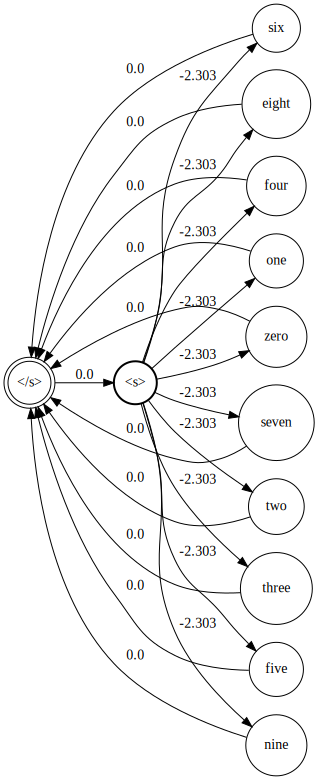

In [62]:
words = keys(lexicon)

# Create a simple unigram language model
lm = FSM{Float64}()
for word in keys(lexicon)
    s = addstate!(lm, label = word)
    link!(initstate(lm), s)
    link!(s, finalstate(lm))
end
link!(finalstate(lm), initstate(lm))

lm = lm |> weightnormalize

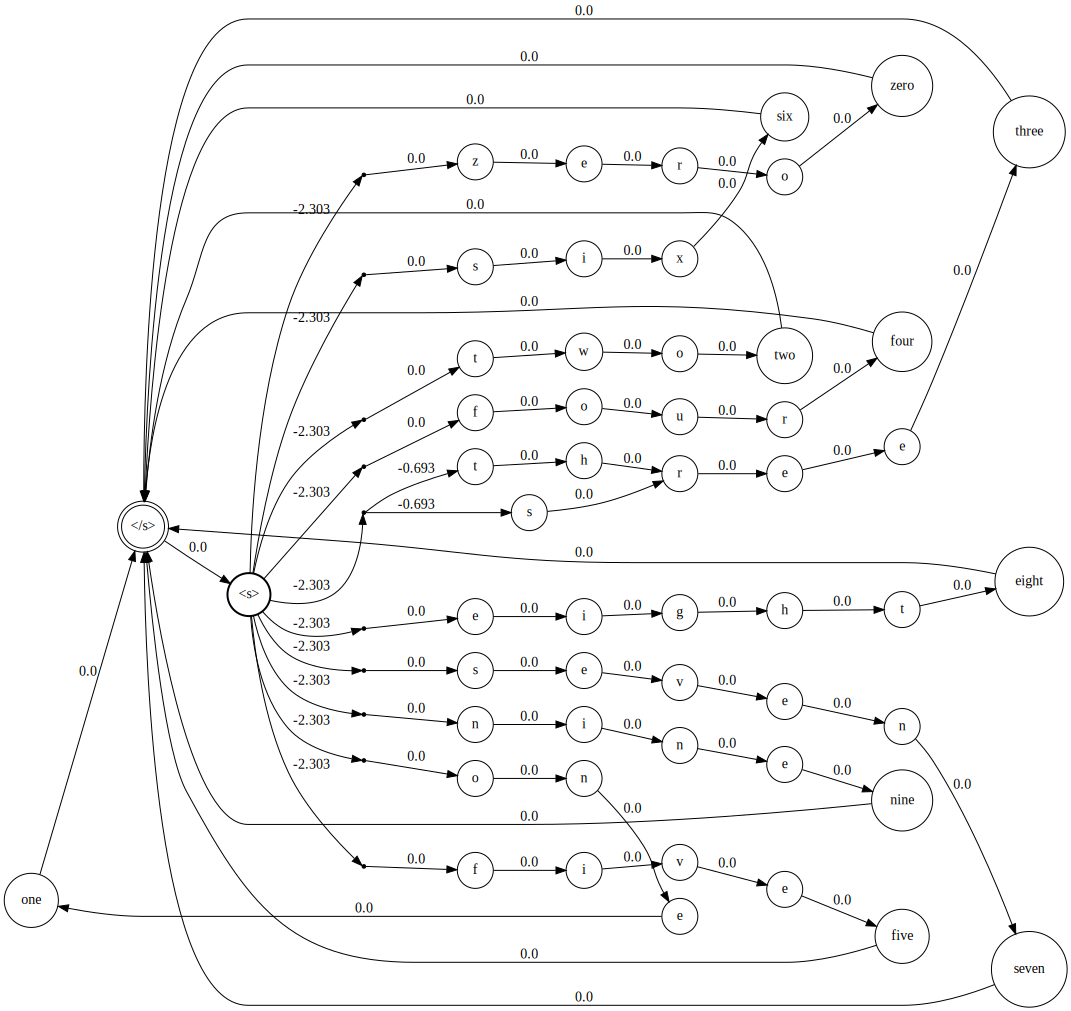

In [63]:
lexicon ∘ lm

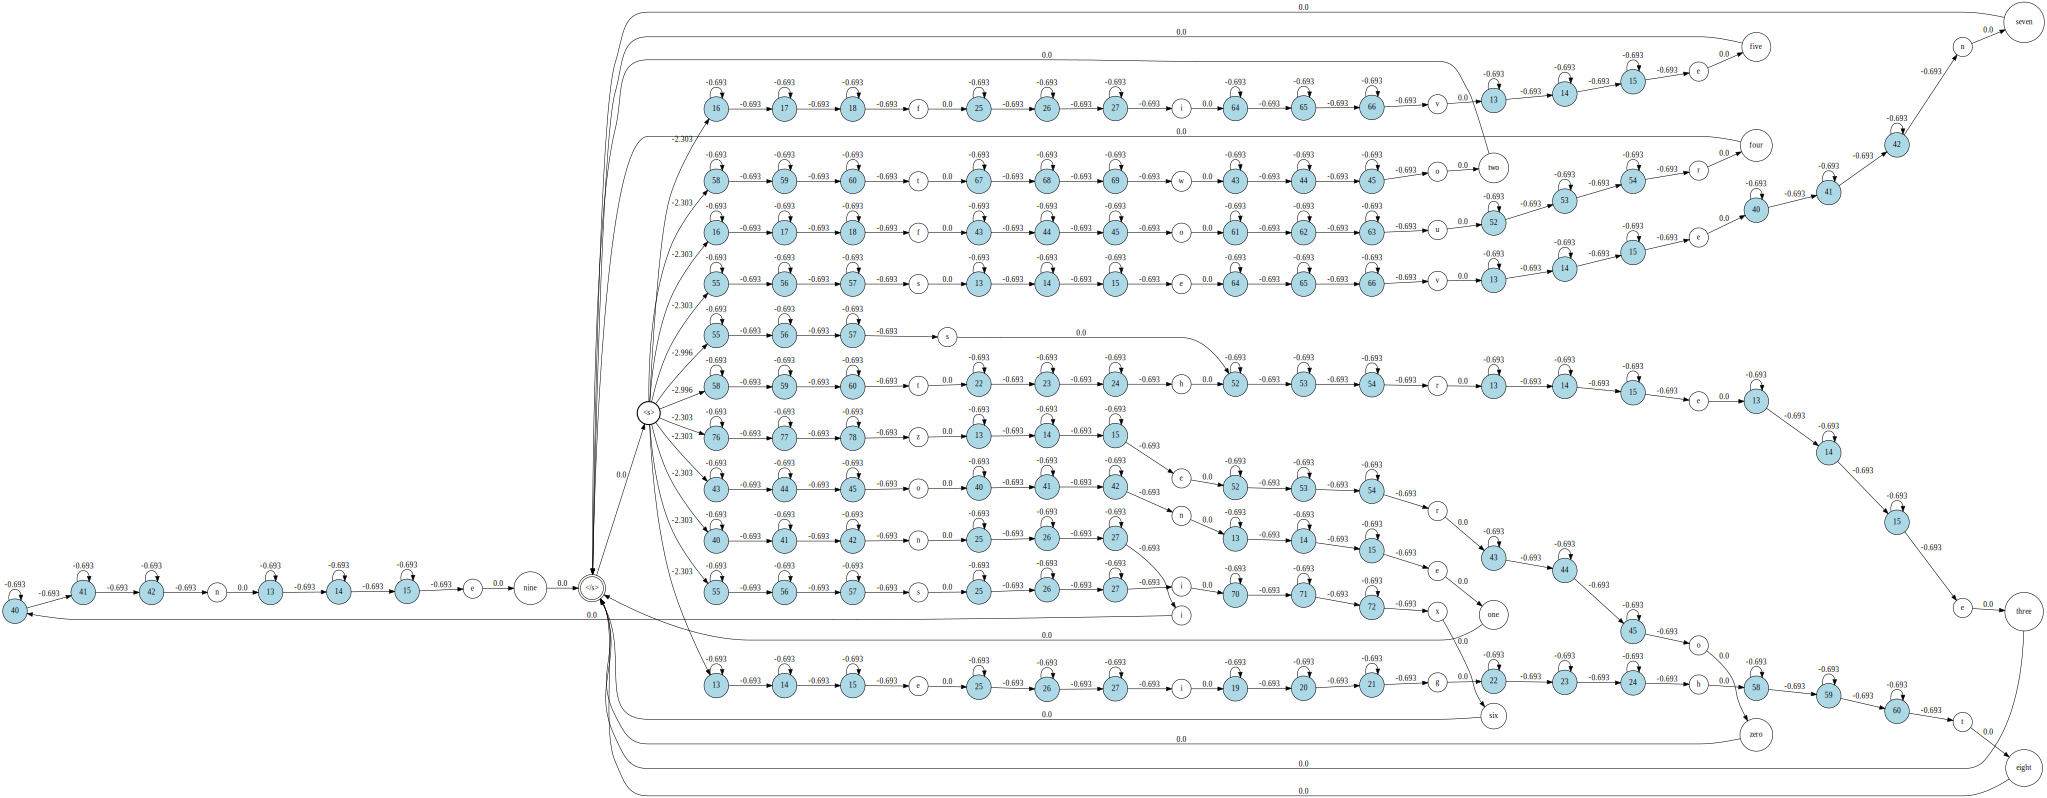

In [64]:
decoder = (hmms ∘ (lexicon ∘ lm)) |> removenilstates

## Generating a lattice

In [80]:
D,N = countpdfs, 100 # number of distributions times number of frames
llh = randn(D, N)

78×100 Array{Float64,2}:
  0.31125   -1.93042    0.4182      …  -1.51424    -0.147836   0.610264
 -0.500827  -0.197352  -0.0299512      -0.0574654   0.19868    0.739885
 -0.241262   0.915909  -2.56334        -1.37        0.989403  -0.360564
 -0.090875   0.254538   0.165983       -1.38675    -1.59357   -1.71758
 -0.414844  -0.908121   0.0640369      -0.718697    0.770487  -1.13918
 -0.724398  -0.996733   1.62888     …  -0.462041    1.361      0.857703
  1.03423    1.33418    0.503316       -0.902225   -1.4465     0.559236
  0.881902  -0.191625  -0.967392        0.355444   -0.764322   0.85261
 -0.588755  -0.989284  -2.19561        -0.253502    0.408746   0.342946
 -2.04633   -0.113788   0.773876       -1.05746    -0.757998  -1.73505
 -0.917934  -0.464033  -0.51958     …   1.47168     0.454713   0.855884
  0.611569   1.25639   -0.443424        0.0493442  -1.25942   -1.84908
  0.955398  -1.25926   -1.3843          0.575341   -0.674161  -1.24911
  ⋮                                 ⋱        

## Decoding 
### Word level

In [81]:
π_best = beststring(decoder, llh, labelfilter = x -> x ∈ keys(lexicon))
join(π_best, " ")

"eight five three five"

### Phone level

In [85]:
π_best = beststring(decoder, llh, labelfilter = x -> x ∈ keys(hmms))
join(π_best, " ")

"e i g h t f i v e s r e e f i v e"

## Sampling path

It is also possible to sample path given the data

### Sampling words

In [86]:
paths = samplestring(decoder, llh, nsamples = 5, labelfilter = x -> x ∈ keys(lexicon)) 
for path in paths
    display(path)
end

4-element Array{Any,1}:
 "eight"
 "five"
 "three"
 "five"

4-element Array{Any,1}:
 "eight"
 "eight"
 "zero"
 "five"

3-element Array{Any,1}:
 "eight"
 "eight"
 "eight"

5-element Array{Any,1}:
 "zero"
 "zero"
 "zero"
 "one"
 "five"

4-element Array{Any,1}:
 "six"
 "zero"
 "eight"
 "eight"

### Sampling phones

In [87]:
paths = samplestring(decoder, llh, nsamples = 5, labelfilter = x -> x ∈ keys(hmms)) 
for path in paths
    display(path)
end

18-element Array{Any,1}:
 "e"
 "i"
 "g"
 "h"
 "t"
 "e"
 "i"
 "g"
 "h"
 "t"
 "f"
 "o"
 "u"
 "r"
 "f"
 "i"
 "v"
 "e"

21-element Array{Any,1}:
 "z"
 "e"
 "r"
 "o"
 "f"
 "i"
 "v"
 "e"
 "n"
 "i"
 "n"
 "e"
 "e"
 "i"
 "g"
 "h"
 "t"
 "f"
 "i"
 "v"
 "e"

20-element Array{Any,1}:
 "e"
 "i"
 "g"
 "h"
 "t"
 "e"
 "i"
 "g"
 "h"
 "t"
 "t"
 "w"
 "o"
 "s"
 "i"
 "x"
 "f"
 "i"
 "v"
 "e"

15-element Array{Any,1}:
 "e"
 "i"
 "g"
 "h"
 "t"
 "e"
 "i"
 "g"
 "h"
 "t"
 "e"
 "i"
 "g"
 "h"
 "t"

15-element Array{Any,1}:
 "s"
 "i"
 "x"
 "f"
 "i"
 "v"
 "e"
 "s"
 "r"
 "e"
 "e"
 "f"
 "i"
 "v"
 "e"